# Cluster GCN on Neo4j

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/connector/neo4j/cluster-gcn-on-cora-neo4j-example.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/connector/neo4j/cluster-gcn-on-cora-neo4j-example.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

This example demonstrates how to run Cluster GCN on a dataset stored entirely on disk with Neo4j. Our Neo4j Cluster GCN implementation iterates through user specified graph clusters and only ever stores the edges and features of one cluster in memory at any given time. This enables Cluster GCN to be used on extremely large datasets that don't fit into memory. 


We use Cora here as an example, see [this notebook](./load-cora-into-neo4j.ipynb) for instructions on how to load the Cora dataset into Neo4j. 

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.1.0b

In [2]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.1.0b")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.1.0b, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [3]:
import stellargraph as sg
from stellargraph.connector.neo4j import Neo4jStellarGraph
from stellargraph.layer import ClusterGCN
from stellargraph.mapper import ClusterNodeGenerator
import tensorflow as tf
import py2neo
import os
from sklearn import preprocessing, feature_extraction, model_selection

import numpy as np
import scipy.sparse as sps
import pandas as pd

## Connect to Neo4j

First we connect to the Neo4j with `py2neo`, we then create a `Neo4jStellarGraph` object.

In [4]:
default_host = os.environ.get("STELLARGRAPH_NEO4J_HOST")

# Create the Neo4j Graph database object;
# the arguments can be edited to specify location and authentication
graph = py2neo.Graph(host=default_host, port=None, user=None, password="pass")
neo4j_sg = Neo4jStellarGraph(graph)

## Data labels

Here we get the node labels. Cluster GCN is semi-supervised and requires labels to be specified for some nodes.

In [5]:
# read the node labels from a seperate file
# note this function also returns a StellarGraph
# which we won't be using for this demo - we only need Neo4jStellarGraph!
_, labels = sg.datasets.Cora().load()

In [6]:
# split the node labels into train/test/val

train_labels, test_labels = model_selection.train_test_split(
    labels, train_size=140, test_size=None, stratify=labels
)
val_labels, test_labels = model_selection.train_test_split(
    test_labels, train_size=500, test_size=None, stratify=test_labels
)

target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_labels)
val_targets = target_encoding.transform(val_labels)
test_targets = target_encoding.transform(test_labels)

## Keras sequences

We now use `StellarGraph` to create keras sequences for taining, testing, and validation. Under the hood, these sequences connect to your Neo4j database and lazily load data for each cluster.

In [7]:
# create the Neo4jClusterNodeGenerator
# and the keras sequence objects

generator = ClusterNodeGenerator(neo4j_sg, clusters=5)

train_gen = generator.flow(train_labels.index, targets=train_targets)
val_gen = generator.flow(val_labels.index, targets=val_targets)
test_gen = generator.flow(test_labels.index, targets=test_targets)

Number of clusters 5
0 cluster has size 541
1 cluster has size 541
2 cluster has size 541
3 cluster has size 541
4 cluster has size 544


## Create and train your model!

Now we create and train the Cluster GCN model.

In [8]:
# create the model
cluster_gcn = ClusterGCN(
    layer_sizes=[32, 32], generator=generator, activations=["relu", "relu"], dropout=0.5,
)

x_in, x_out = cluster_gcn.in_out_tensors()
predictions = tf.keras.layers.Dense(units=val_targets.shape[1], activation="softmax")(
    x_out
)
model = tf.keras.Model(x_in, predictions)
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.01),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=["acc"],
)

In [9]:
# train the model!
history = model.fit(train_gen, validation_data=val_gen, epochs=10)

  ['...']
  ['...']
Train for 5 steps, validate for 5 steps
Epoch 1/10
5/5 [==============================] - 5s 1s/step - loss: 1.9063 - acc: 0.2500 - val_loss: 1.8195 - val_acc: 0.3020
Epoch 2/10
5/5 [==============================] - 5s 954ms/step - loss: 1.7024 - acc: 0.3000 - val_loss: 1.6901 - val_acc: 0.3060
Epoch 3/10
5/5 [==============================] - 5s 954ms/step - loss: 1.5102 - acc: 0.3929 - val_loss: 1.5511 - val_acc: 0.4360
Epoch 4/10
5/5 [==============================] - 5s 985ms/step - loss: 1.3074 - acc: 0.5714 - val_loss: 1.3999 - val_acc: 0.5360
Epoch 5/10
5/5 [==============================] - 5s 965ms/step - loss: 1.0225 - acc: 0.7071 - val_loss: 1.2929 - val_acc: 0.5640
Epoch 6/10
5/5 [==============================] - 5s 979ms/step - loss: 0.8131 - acc: 0.7571 - val_loss: 1.1961 - val_acc: 0.6000
Epoch 7/10
5/5 [==============================] - 5s 990ms/step - loss: 0.6240 - acc: 0.7929 - val_loss: 1.1764 - val_acc: 0.5840
Epoch 8/10
5/5 [=================

In [10]:
# evaluate the model
model.evaluate(test_gen)

  ['...']
5/5 [==============================] - 2s 497ms/step - loss: 1.1848 - acc: 0.6306


[1.1847997188568116, 0.63056093]

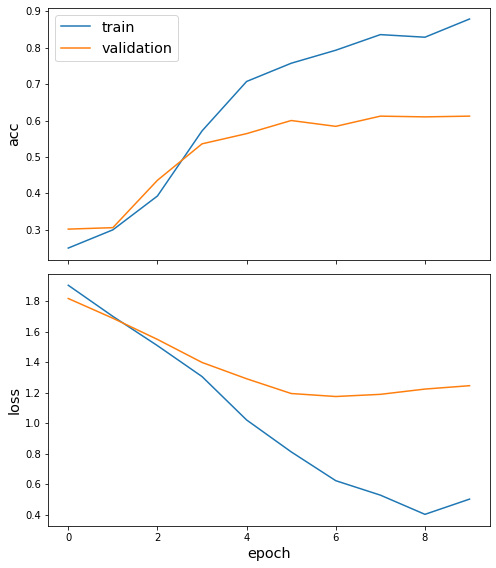

In [11]:
sg.utils.plot_history(history)

And that's it! We've trained a graph neural network without ever loading the whole graph into memory.

Please refer to [cluster-gcn-node-classification](./../../node-classification/cluster-gcn-node-classification.ipynb) for **node embedding visualization**.

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/connector/neo4j/cluster-gcn-on-cora-neo4j-example.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/connector/neo4j/cluster-gcn-on-cora-neo4j-example.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>